In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import os

from IPython.display import display, HTML
BASE_FOLDER = ".."
CONFIGURATION_INPUT_FILE = "configuration-input-new.csv"
COMPONENT_TO_ANALYZE = "host" # host / server / service

In [42]:
def list_directories(directory):
    return [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]

In [43]:
def most_recent_directory(directory):
    dirs = list_directories(directory)
    if not dirs:
        return None
    
    most_recent = max(dirs, key=lambda d: os.path.getctime(os.path.join(directory, d)))
    return os.path.join(directory, most_recent)

In [44]:
def mean_of_chunks(series, chunk_size):
    # Explicitly setting numeric_only to True to avoid FutureWarning about deprecation
    return series.groupby(np.arange(len(series)) // chunk_size).mean(numeric_only=True)

In [45]:
def retrieve_metrics():
    input_path = f"{BASE_FOLDER}/input/{CONFIGURATION_INPUT_FILE}"
    with open(input_path, 'r') as file:
        lines = file.readlines()
        second_line = lines[1]  # get the second line
        second_line_elements = second_line.split(',')  # split the line by comma

    df = pd.read_csv(input_path, sep=",")
    all_metrics = []
    read_value = ""
    found_number = False
    index_of_metrics = len(df.columns) - 2

    while not found_number:
        read_value = df.iloc[0, index_of_metrics]
        try:
            int(read_value)
            found_number = True
        except ValueError:
            all_metrics.append(df.iloc[0, index_of_metrics])
            index_of_metrics -= 1

    return all_metrics[::-1]

all_metrics = retrieve_metrics()

In [46]:
all_performance_metrics = ['cpu_limit', 'cpu_usage', 'cpu_demand', 'cpu_utilization', 'cpu_time_active', 'cpu_time_idle', 'cpu_time_steal', 'cpu_time_lost']
all_energy_metrics = ['power_total']
        
selected_performance_metrics = [metric for metric in all_metrics if metric in all_performance_metrics]
selected_energy_metrics = [metric for metric in all_metrics if metric in all_energy_metrics]

print(selected_performance_metrics)
print(selected_energy_metrics)

['cpu_limit', 'cpu_usage', 'cpu_utilization', 'cpu_time_active']
['power_total']


In [47]:

path = f"{BASE_FOLDER}/output/{COMPONENT_TO_ANALYZE}/workload=bitbrains-small/seed=0/"

recent_dir = most_recent_directory(path)
simulation_files = os.listdir(recent_dir)
simulation_data = []

for file in simulation_files:
    simulation_data.append(
        mean_of_chunks(pd.read_parquet(os.path.join(recent_dir, file)), 1000)
    )
    
simulation_data[0]

,hosts_up,hosts_down,servers_pending,servers_active,attempts_success,attempts_failure,attempts_error
0,9.0,0.0,0.000,44.000000,44.000,0.0,0.0
1,9.0,0.0,0.000,44.000000,44.000,0.0,0.0
2,9.0,0.0,0.003,45.307000,45.307,0.0,0.0
3,9.0,0.0,0.000,47.000000,47.000,0.0,0.0
4,9.0,0.0,0.002,47.184000,47.184,0.0,0.0
5,9.0,0.0,0.000,49.000000,49.000,0.0,0.0
6,9.0,0.0,0.001,49.109000,49.443,0.0,0.0
7,9.0,0.0,0.000,48.000000,50.000,0.0,0.0
8,9.0,0.0,0.000,47.856698,50.000,0.0,0.0


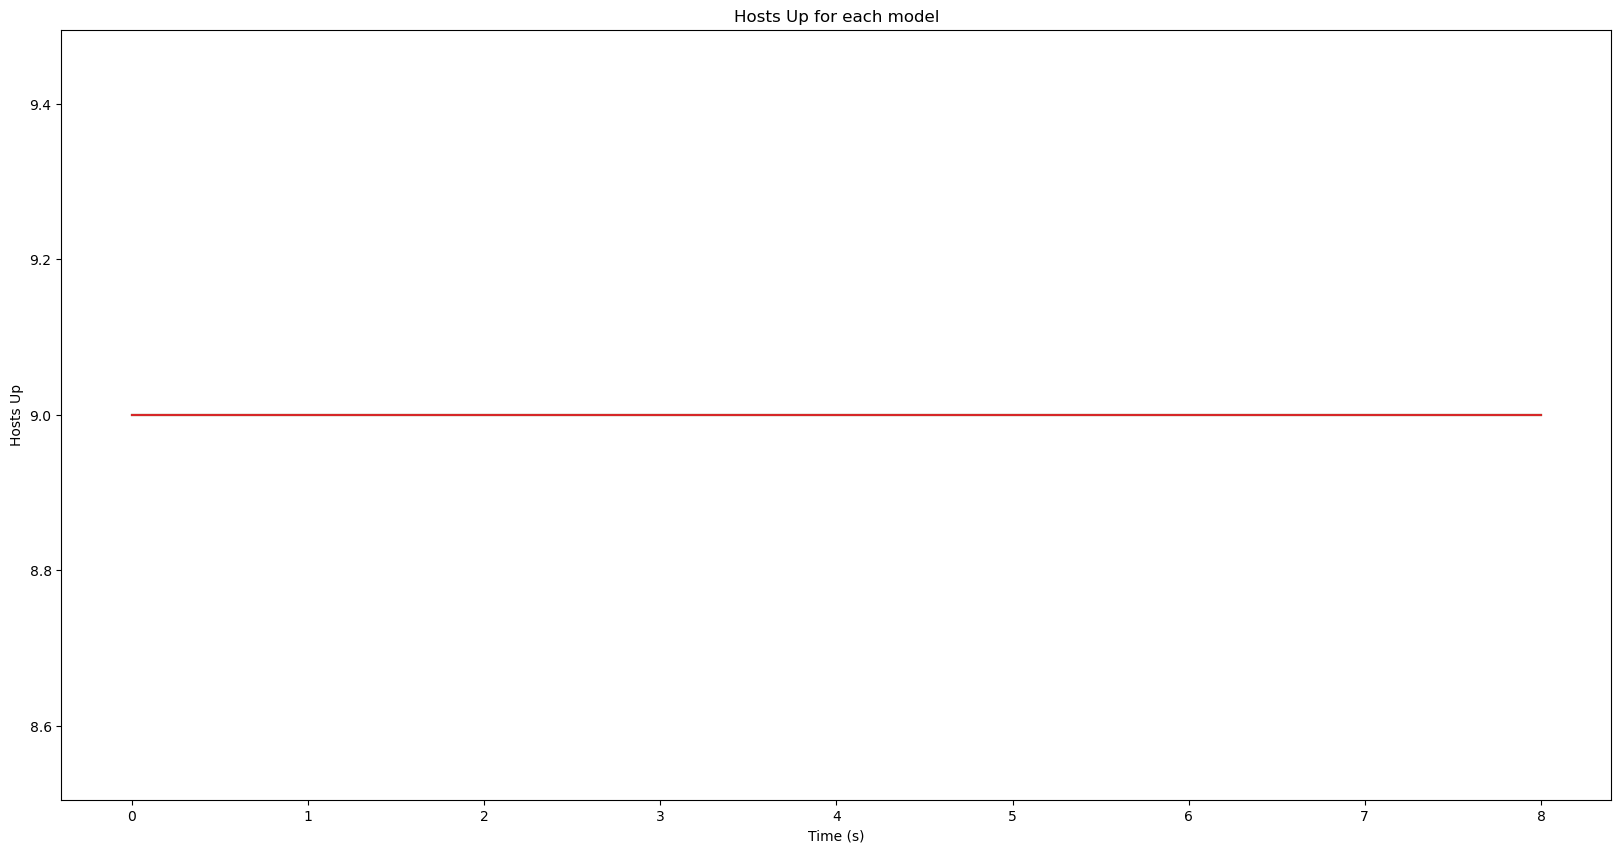

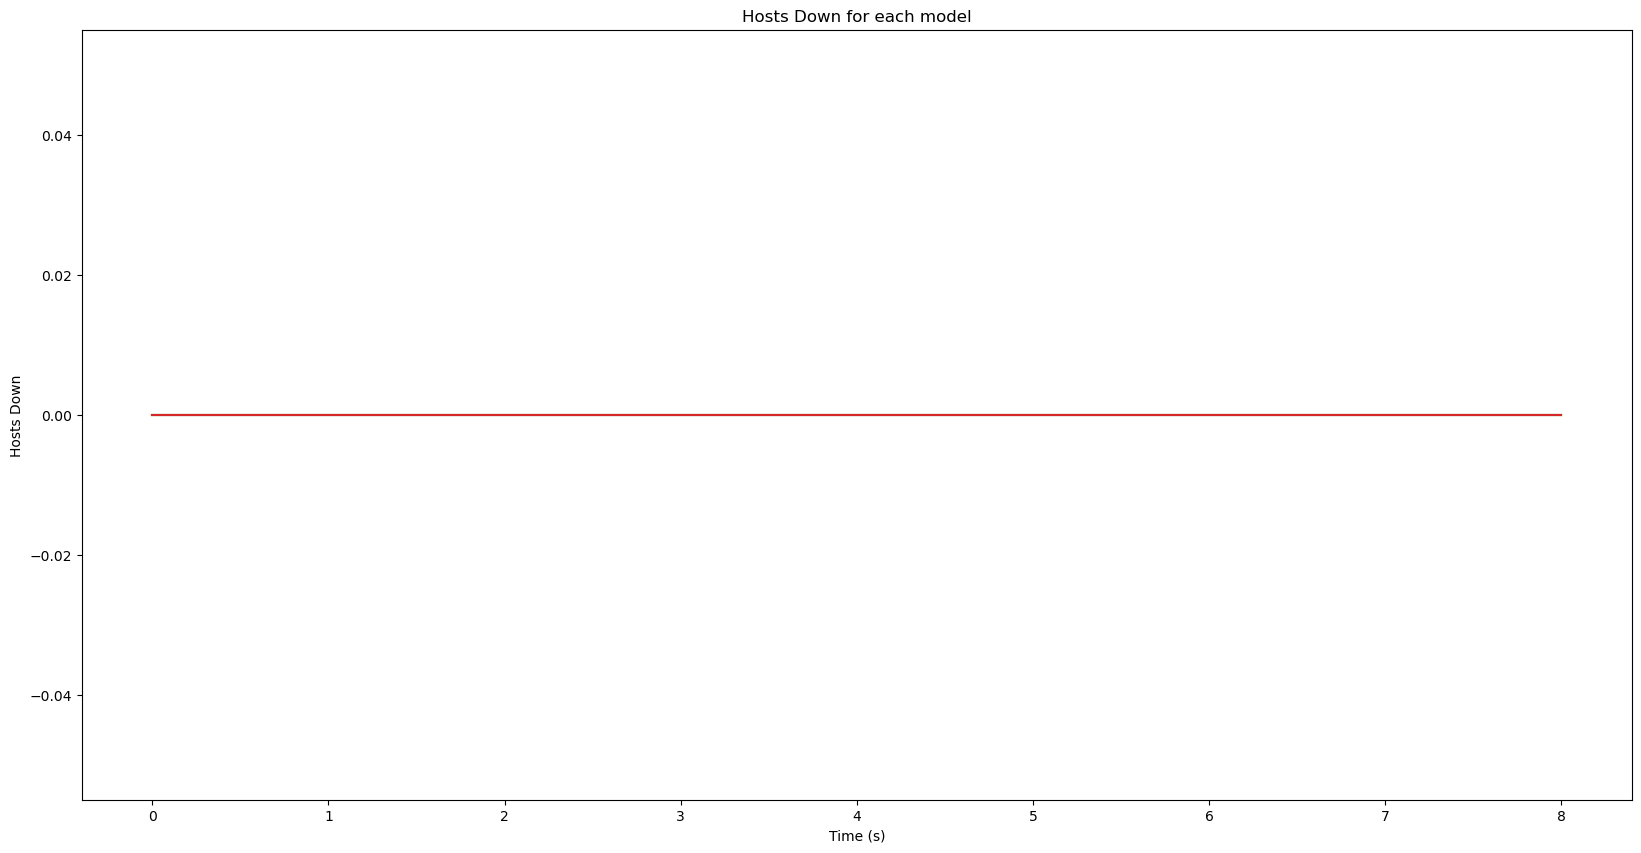

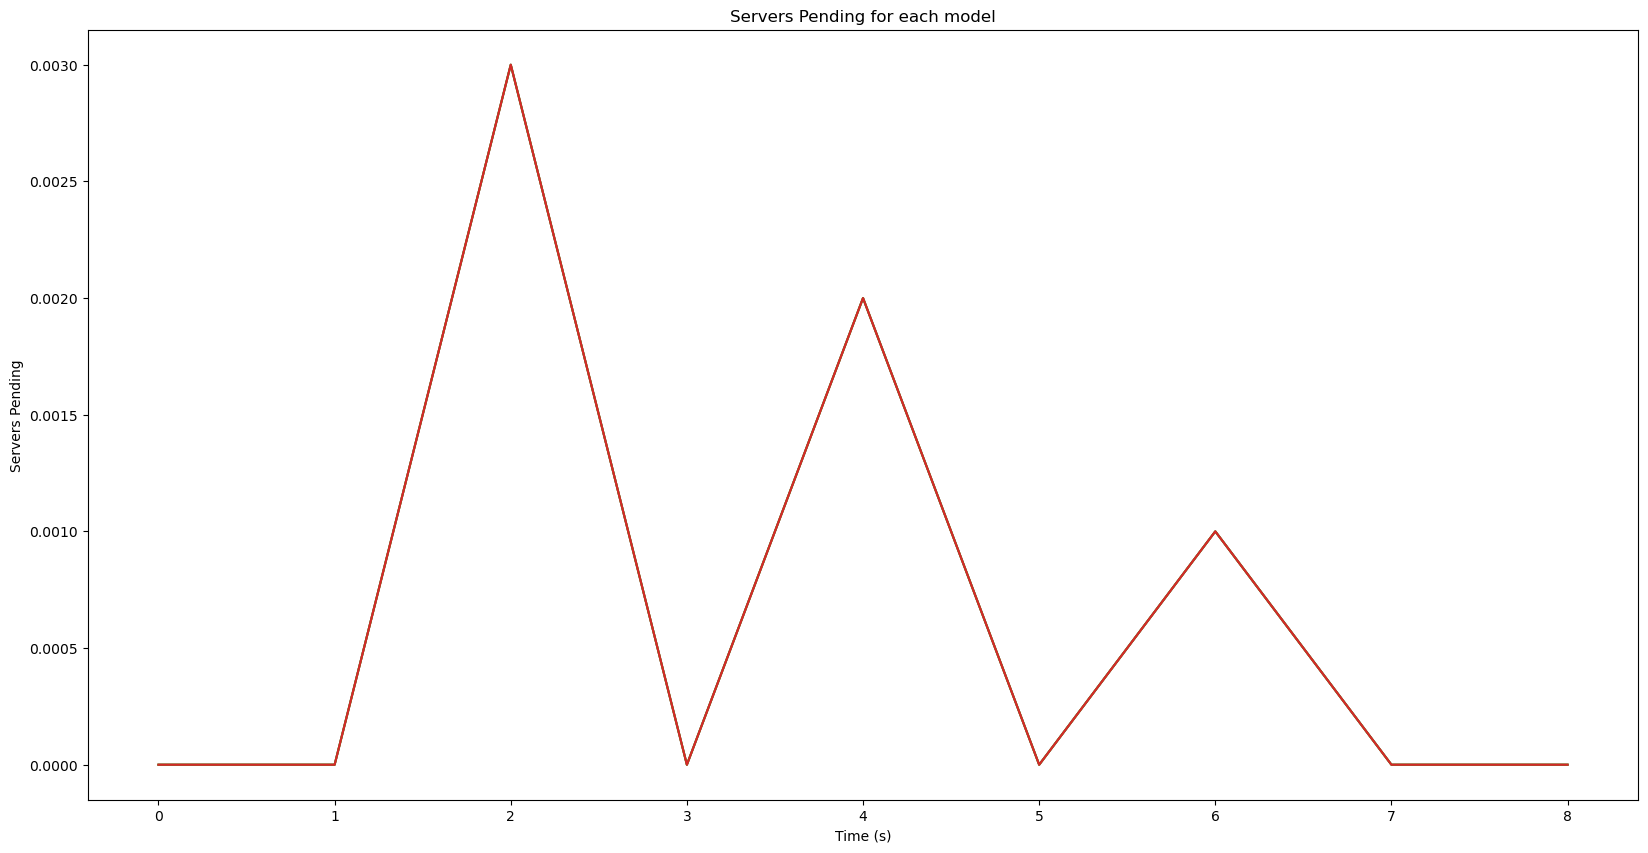

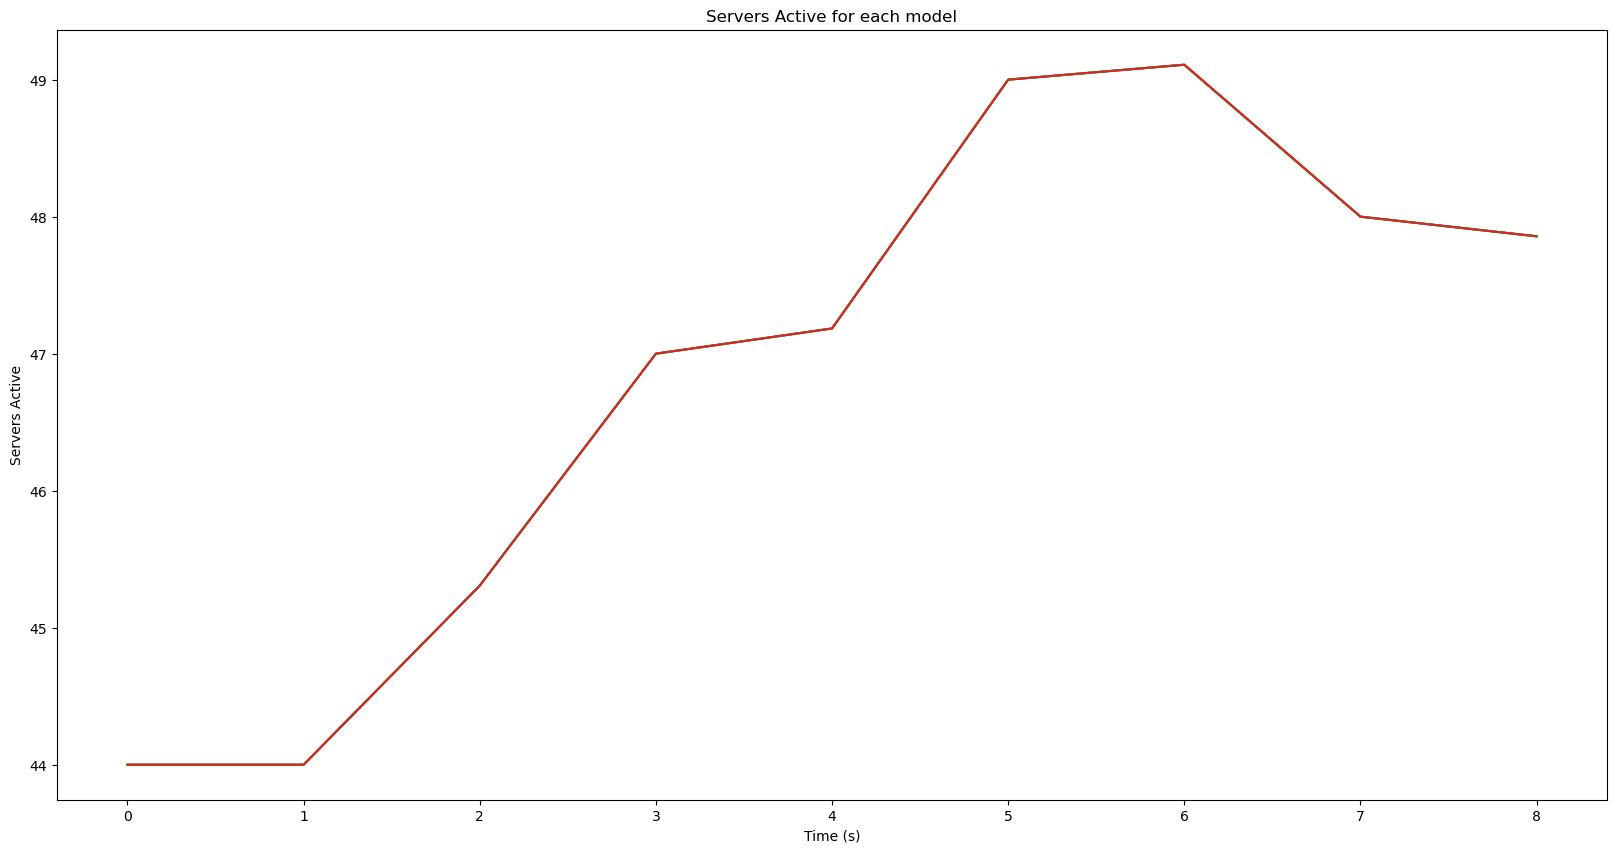

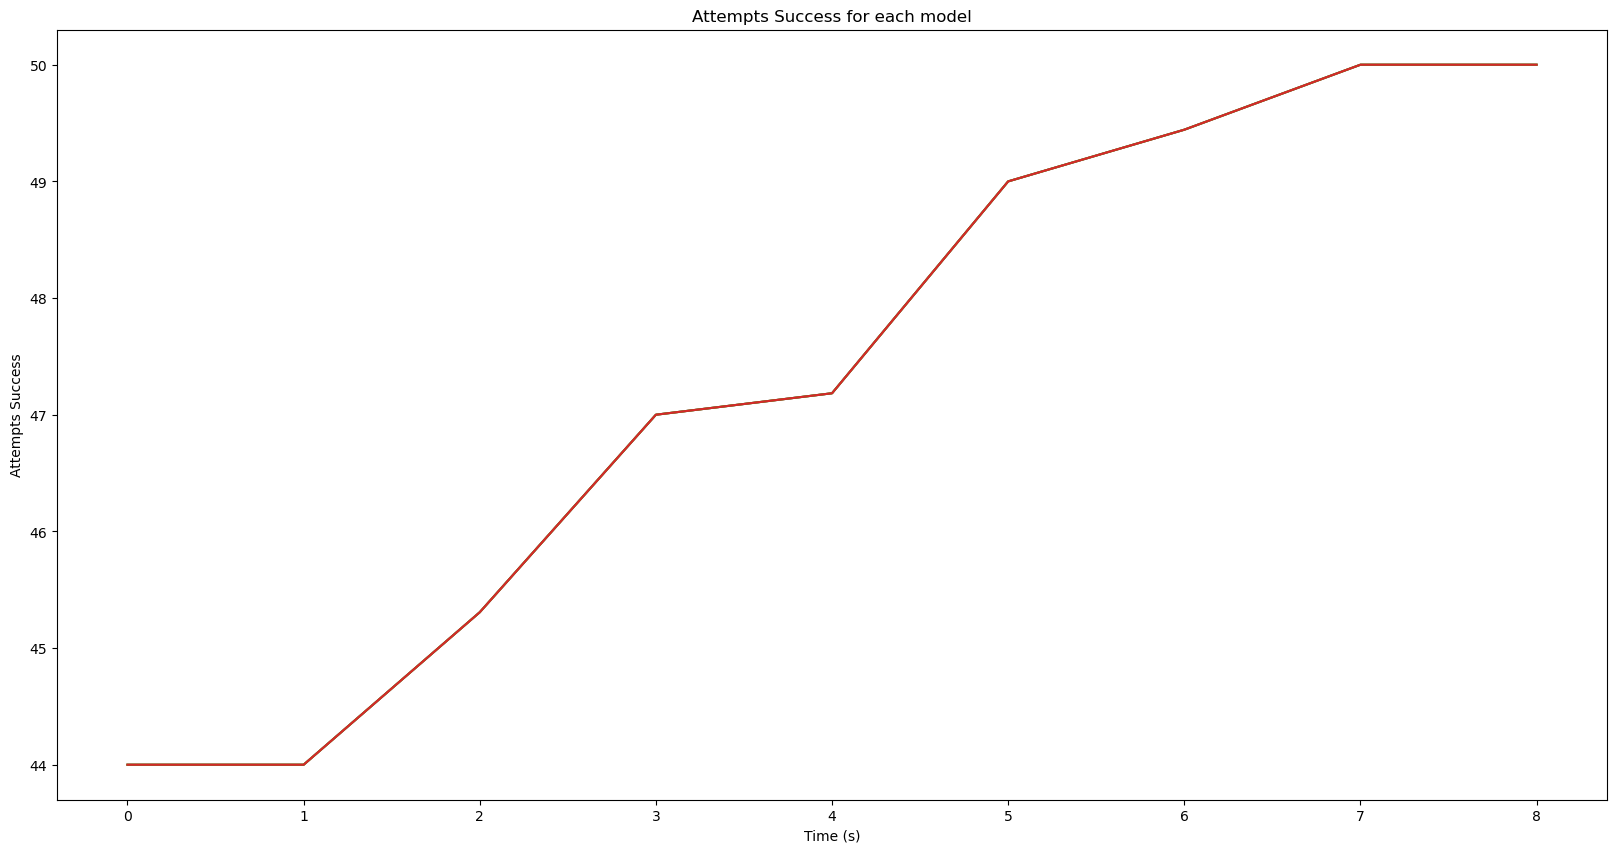

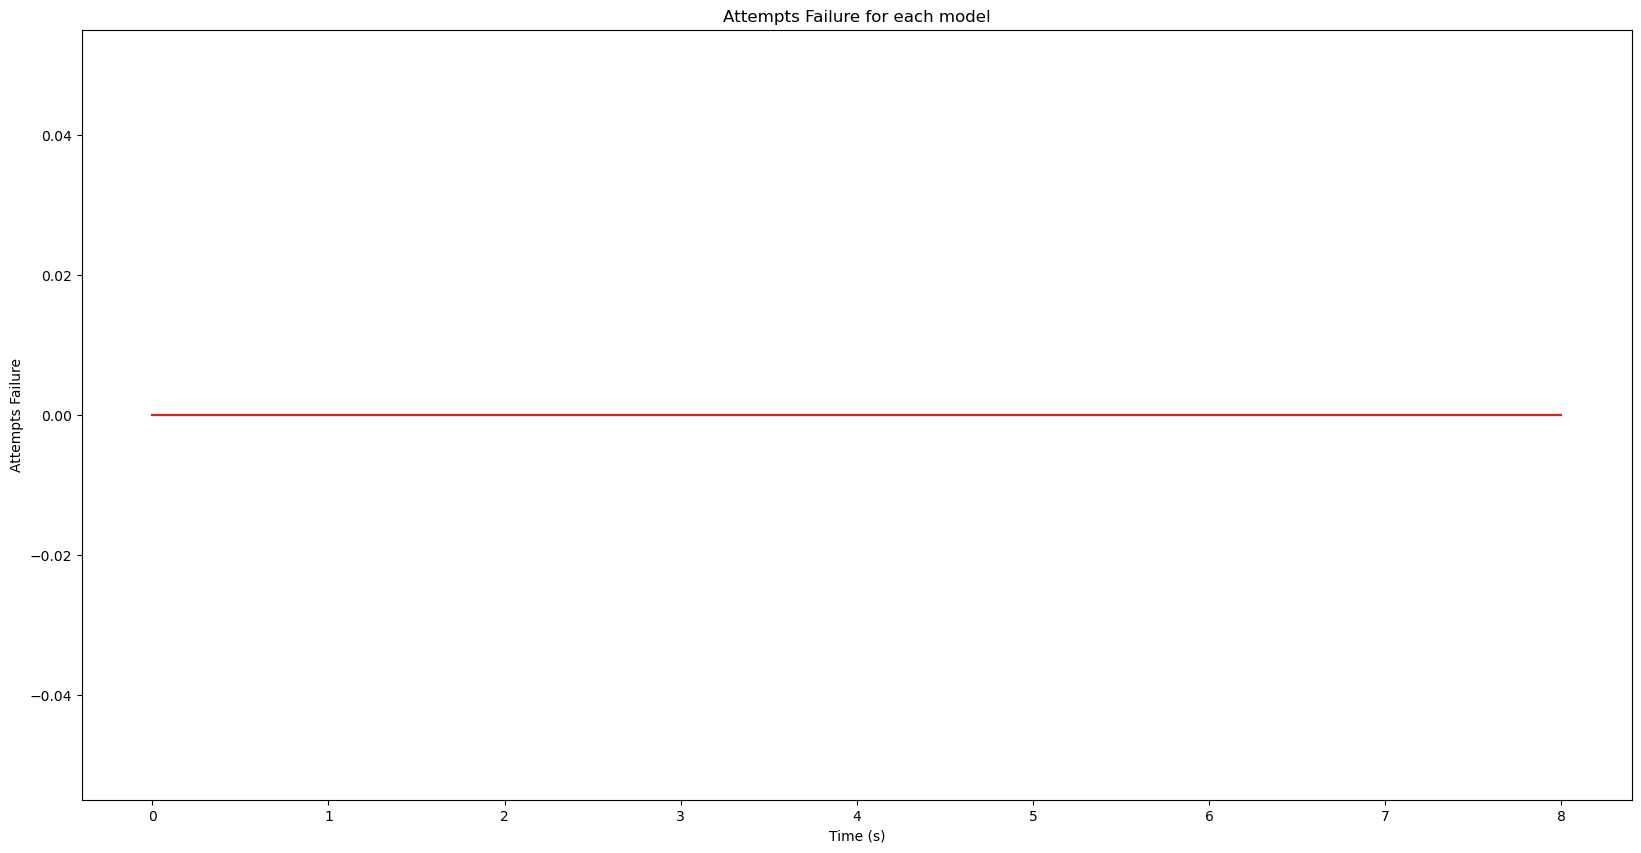

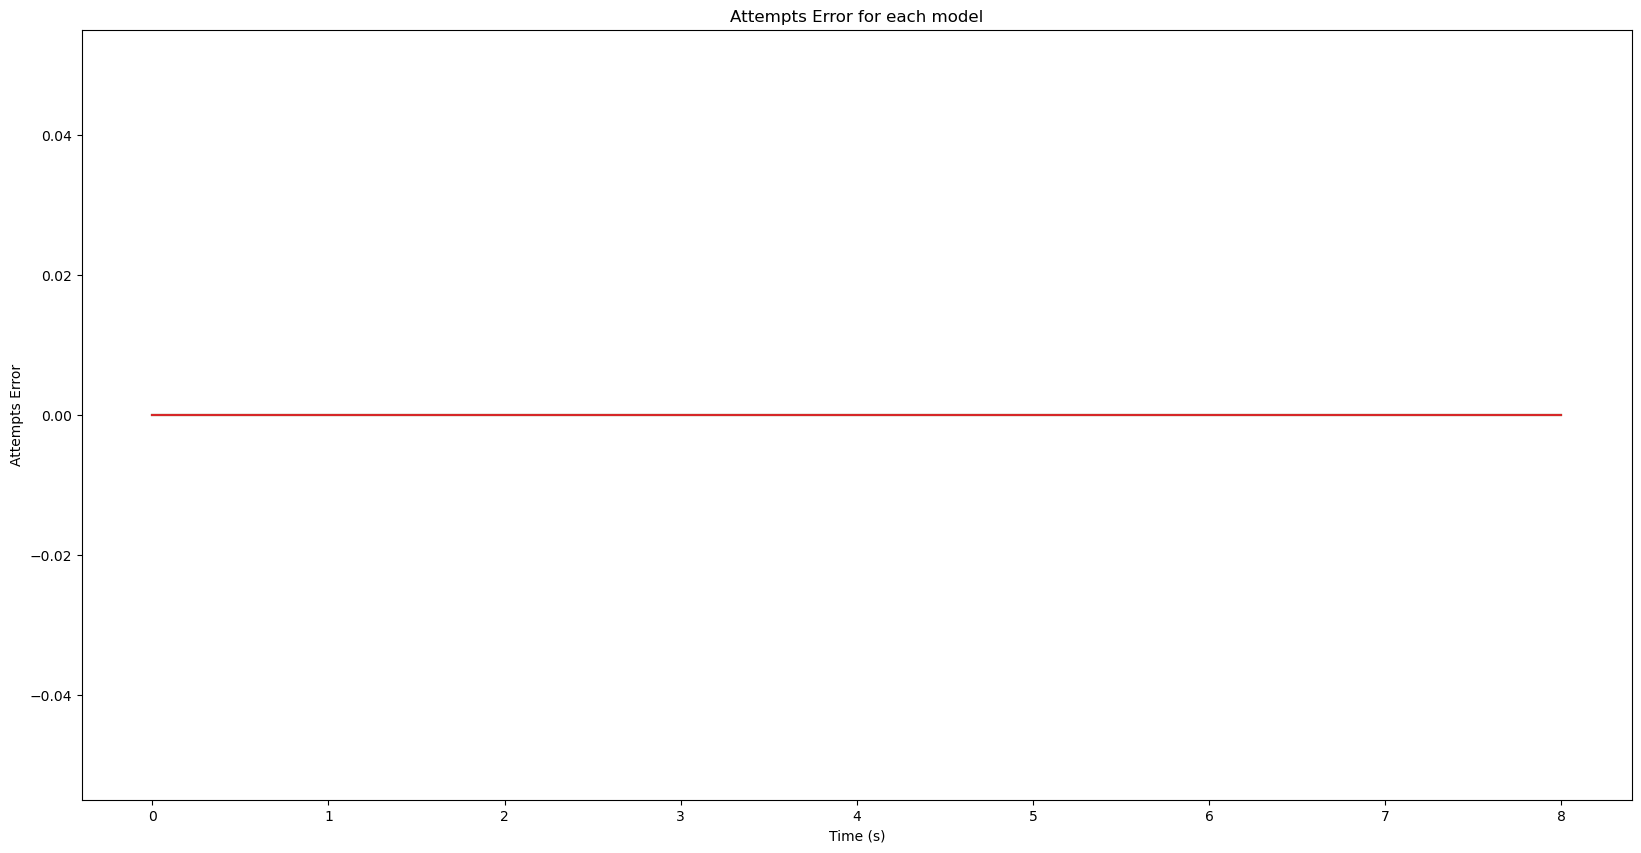

In [48]:
from plotter import DataPlotter
plotter = DataPlotter(simulation_data)

if (COMPONENT_TO_ANALYZE == "server"):
    plotter.plot_mem_capacity()
    plotter.plot_cpu_count()
    plotter.plot_cpu_limit()
    plotter.plot_cpu_time_active()
    plotter.plot_cpu_time_idle()
    plotter.plot_cpu_time_steal()
    plotter.plot_cpu_time_lost()
elif (COMPONENT_TO_ANALYZE == "host"):
    plotter.plot_cpu_count()
    plotter.plot_mem_capacity()
    plotter.plot_guests_terminated()
    plotter.plot_guests_running()
    plotter.plot_guests_error()
    plotter.plot_guests_invalid()
    plotter.plot_cpu_limit()
    plotter.plot_cpu_usage()
    plotter.plot_cpu_demand()
    plotter.plot_cpu_utilization()
    plotter.plot_cpu_time_steal()
    plotter.plot_servers_active()
    plotter.plot_cpu_time_idle()
    plotter.plot_cpu_time_lost()
    plotter.plot_power_total()
elif (COMPONENT_TO_ANALYZE == "service"):
    plotter.plot_hosts_up()
    plotter.plot_hosts_down()
    plotter.plot_servers_pending()
    plotter.plot_servers_active()
    plotter.plot_attempts_success()
    plotter.plot_attempts_failure()
    plotter.plot_attempts_error()